In [169]:
import Pkg; Pkg.activate(joinpath(@__DIR__,".")); Pkg.instantiate();
using LinearAlgebra;
using Plots;
using StaticArrays;
using ForwardDiff;
using RobotZoo;
using RobotDynamics;
using MeshCat;
using TrajOptPlots;

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\16-745\final-project\Project.toml`


We know the dynamics are of the following:
            $$q = \begin{bmatrix}
                  x_{foot}    \\
                  y_{foot}   \\
                  \alpha \\
                  \beta  \\
                  \end{bmatrix}$$
where $\alpha$ is the top revolute joint and $\beta$ is the middle revolute joint
And normally for a single dynamics phase,
$$ dx = \delta_{(x, 1)} f_{1}(x, u) + \delta_{(x, 2)} f_{2}(x, u)$$

which is pretty much a guard function.

           
           
           
           
           

In [310]:
struct Hopper
    ml
    mh
    l
    la
    lb
    function Hopper(ml, mh, l, la, lb)
        new(ml, mh, l, la, lb)
    end
end


function get_q_double_dot(hopper, x, u, ballistic)
    ml = hopper.ml
    mh = hopper.mh
    l = hopper.l
    a = hopper.la
    b = hopper.lb
    
    # q = x[1:4]
    ξ = x[1]
    η = x[2]
    α = x[3]
    β = x[4]
    
    # qdot = x[5:8]
    ξdot = x[5]
    ηdot = x[6]
    αdot = x[7]
    βdot = x[8]
    # println(η)
    
    g = 9.81
    
    if (ballistic)
        # Mass matrix
        m11 = mh + 2 *ml
        m12 = 0
        m13 = -mh*l*sin(α) - ml*(a*sin(α)+l*sin(α) + b*sin(α+β))
        m14 = -ml*b*sin(α+β)
        
        m23 = mh*l*cos(α) + ml*(a*cos(α)+l*cos(α)+b*cos(α+β))
        m24 = ml*b*cos(α+β)
        m33 = mh*l^2 + ml*(a^2+b^2+l^2+2*b*l*cos(β))
        m34 = ml*b*(b+l*cos(β))
        m44 = ml*b^2
        
        M = [m11 m12 m13 m14        
             m12 m11 m23 m24
             m13 m23 m33 m34
             m14 m24 m34 m44]
        
        # Gravitational effects + velocity
        n1 = -(mh*l+ml*a+ml*l)*cos(α)*αdot^2 - ml*b*cos(α+β)*(αdot+βdot)^2
        n2 = -(mh*l+ml*a+ml*l)*sin(α)*αdot^2 - ml*b*sin(α+β)*(αdot+βdot)^2 + mh*g + 2*ml*g
        n3 = -ml*b*l*sin(β)*(βdot^2+αdot*βdot) + (mh*l+ml*a+ml*l)*g*cos(α) + ml*b*g*cos(α+β)
        n4 = ml*b*l*sin(β)*αdot^2 + ml*b*g*cos(α+β)
        n = [n1; n2; n3; n4]
        
        # Accelerations
        qdd = M \ ([0; 0; u] .- n)
        
    else
        # Mass matrix
        m11 = mh*l^2 + ml*(a^2+b^2+l^2+2*b*l*cos(β))
        m12 = ml*b*(b+l*cos(β))
        m22 = ml*b^2
        M = [m11 m12
             m12 m22]
        
        # Combined velocity and acceleration
        n1 = -ml*b*l*sin(β)*(βdot^2+2*αdot*βdot) + (mh*l+ml*a+ml*l)*g*cos(α) + ml*b*g*cos(α+β)
        n2 = ml*b*l*sin(β)*αdot^2 + ml*b*g*cos(α+β)
        n = [n1; n2]
        
        # Friction
        c = 1.0
        C = [c*αdot; c*βdot]
    
        qdd = M \ (u .- n .- C)
       
        qdd = [0; 0; qdd]
        
    end
    return qdd
end
        

function discrete_dynamics_hop(hopper, x, u, ballistic)
    # assuming x is of the form [q; qdot]
    qdot = x[5:8]
    qdd = get_q_double_dot(hopper, x, u, ballistic)
    # println(qdd)
    return [qdot; qdd]
end


function jump_map(x)
    xn = [x[1:4]; 0.0; 0.0; x[7:8]]
    return xn
end


function rk4_dynamics!(hopper, x, u, ballistic, h)
    k1 = discrete_dynamics_hop(hopper, x, u, ballistic)
    k2 = discrete_dynamics_hop(hopper, x+0.5*h*k1, u, ballistic)
    k3 = discrete_dynamics_hop(hopper, x+0.5*h*k2, u, ballistic)
    k4 = discrete_dynamics_hop(hopper, x+h*k3, u, ballistic)
    # println("K1", k1)
    # println("K2", k2)
    # println("K3", k3)
    # println("K4", k4)
    
    x .= x .+ (h/6.0) * (k1+2*k2+2*k3+k4)
    return nothing
    # return (x + (h/6) * (k1+2*k2+2*k3+k4)
    # return nothing
end


function foot_coords(hopper, x)
    l = hopper.l
    
    e = x[1]
    n = x[2]
    a = x[3]
    b = x[4]
    
    edot = x[5]
    ndot = x[6]
    adot = x[7]
    bdot = x[8]
    
    T = zero(x)
    T[1] = e + l*cos(a) + l*cos(a + b)
    T[2] = n + l*sin(a) + l*sin(a + b)
    T[3] = a + b - pi
    T[4] = 2*pi - b
    T[5] = edot + l*cos(a)*adot + l*cos(a+b)*(adot+bdot)
    T[6] = ndot - l*sin(a)*adot - l*sin(a+b)*(adot+bdot)
    T[7] = adot + bdot
    T[8] = -bdot
    return T
end


foot_coords (generic function with 1 method)

In [282]:
# Test the foot coords. The description for both is from the vertical
begin
    x0 = [0.0; 0.0; pi/4; -pi/2; 0.0; 0.0; 0.0; 0.0]
    hopper = Hopper(5, 10, 1, 0.5, 0.5)
    fx = foot_coords(hopper, x0)
    regCoords = foot_coords(hopper, fx)
    println(fx)
    # 3 println(regCoords)
end

[1.4142135623730951, 0.0, -3.9269908169872414, 7.853981633974483, 0.0, 0.0, 0.0, -0.0]


Begin


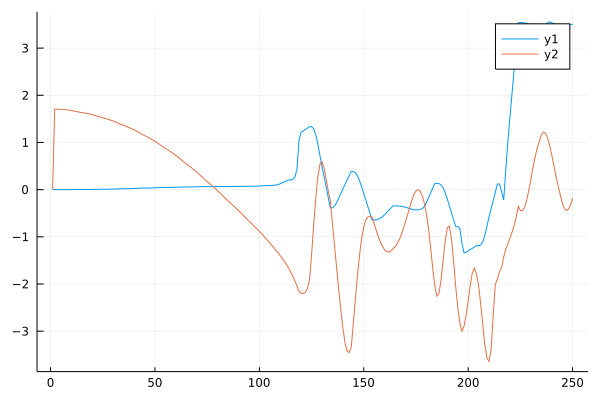

In [308]:
# Stance and flight testtest
begin
    x0 = [0; 0; pi/4; pi/4; 0; 0; 0; 0]
    # u0 = 2
    h = 0.01
    hopper = Hopper(5, 10, 1, 0.5, 0.5)
    T = 250
    modes = zeros(T)
    
    m = 1
    change = 1
    for i = 1:T
        modes[i] = m
        if mod(i, 5) == 0
            m += change
            # println("flop")
            change = change * -1
        end
    end      
        
    Xs = zeros(T, 8)
    println("Begin")
    Fxs = zeros(T, 8)
    x = x0
    # println(x)
    Xs[1, :] .= x0
    u = [0.0; 0.0]
    for i = 2:T
        if modes[i] == 1
            if mod(i, 5) == 0
                x[5:6] .= 0.0
            end
            u = [0.0; 1.0]
            rk4_dynamics!(hopper, x, u, false, h)
        else
            # println("Flying")
            u = [0.0; 0.0]
            rk4_dynamics!(hopper, x, u, true, h)
            # println("flight")
        end 
        Xs[i, :] .= x
        Fxs[i, :] .= foot_coords(hopper, x)
    end
    
    plot(Xs[:, 1])
    plot!(Fxs[:, 2])
end

In [71]:
# Equilibrium point
begin
    x0 = [0; 0; 2*pi/3; -pi/3; 0; 0; 0; 0]
    uguess = [0.0; 0.0]
    ueq = copy(uguess)
    h = 0.01
    hopper = Hopper(5, 10, 1, 0.5, 0.5)
    T = 200
    # Xs = zeros(T, 8)
    λ = zeros(2)
    # Us = [zero(u0) for i = 1:T]
    c = discrete_dynamics(hopper, x0, ueq, false)[5:6]
    dfdb = ForwardDiff.jacobian(u->discrete_dynamics(hopper, x0, u, false), ueq)
    reldb = dfdb[5:6, :]
    gradb = (ueq - uguess) + reldb' * λ
    kkt_vec = [gradb; c]
    tol = 1e-4
    count = 1
    limit = 25
    # println("Begin")
    # println(kkt_vec)
    # println(dfdb)while (norm(kkt_vec) > tol) && (count < iters)
#         kkt_mat = [I(4) relB';
#                    relB zeros(6, 6)]
#         kkt_mat = kkt_mat .+ Diagonal([ones(4); -ones(6)])*1e-4
        
#         deltas = - kkt_mat \ kkt_vec
#         du = deltas[1:length(u_trim)]
#         dl = deltas[5:end]
#         u_trim = u_trim + du
#         λ = λ + dl
#         # println(deltas)
        
        
#         B = ForwardDiff.jacobian(u->dynamics(model, x_trim, u), u_trim)
#         # cut down B
#         relB = B[end-5:end, :]
#         count = count + 1
        
#         c = dynamics(model, x_trim, u_trim)[end-5:end]
#         ∇Lu = (u_trim - u_guess) + relB' * λ
#         kkt_vec = [∇Lu; c]
#     end
    
    while (norm(kkt_vec) > tol) && (count < limit)
        kkt_mat = [I(2)    reldb';
                   reldb   zeros(2, 2)]
        kkt_mat = kkt_mat .+ Diagonal([ones(2); -ones(2)])*1e-4
        deltas = -kkt_mat \ kkt_vec
        
        delU = deltas[1:length(uguess)]
        delλ = deltas[length(uguess)+1:end]
        # println(delU)
        ueq = ueq + delU
        λ = λ + delλ
        c = discrete_dynamics(hopper, x0, ueq, false)[5:6]
        dfdb = ForwardDiff.jacobian(u->discrete_dynamics(hopper, x0, u, false), ueq)
        reldb = dfdb[5:6, :]
        gradb = (ueq - uguess) + reldb' * λ
        kkt_vec = [gradb; c]
        # println(norm(kkt_vec))
    end
    # println(ueq)
end

LoadError: MethodError: no method matching discrete_dynamics(::Hopper, ::Array{Float64,1}, ::Array{Float64,1}, ::Bool)
Closest candidates are:
  discrete_dynamics(!Matched::Type{PassThrough}, !Matched::LinearModel, ::Any, ::Any, !Matched::Any, !Matched::Any) at C:\Users\brand\.julia\packages\RobotDynamics\e9xEC\src\linearmodel.jl:126
  discrete_dynamics(!Matched::Type{PassThrough}, !Matched::LinearizedModel, ::Any, ::Any, !Matched::Any, !Matched::Any) at C:\Users\brand\.julia\packages\RobotDynamics\e9xEC\src\linearization.jl:109
  discrete_dynamics(!Matched::Type{Q}, !Matched::AbstractModel, ::Any, ::Any, !Matched::Any, !Matched::Any) where Q at C:\Users\brand\.julia\packages\RobotDynamics\e9xEC\src\model.jl:300

In [259]:
function equilibrium(hopper, x, uguess, ballistic, params)
    ueq = copy(uguess)
    λ = zeros(2)
    
    c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
    dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, ballistic), ueq)
    reldb = dfdb[params, :]
    gradb = (ueq - uguess) + reldb' * λ
    kkt_vec = [gradb; c]
    tol = 1e-4
    count = 1
    limit = 25
    
    while (norm(kkt_vec) > tol) && (count < limit)
        kkt_mat = [I(2)    reldb';
                   reldb   zeros(2, 2)]
        kkt_mat = kkt_mat .+ Diagonal([ones(2); -ones(2)])*1e-4
        deltas = -kkt_mat \ kkt_vec

        delU = deltas[1:length(uguess)]
        delλ = deltas[length(uguess)+1:end]
    
        ueq = ueq + delU
        λ = λ + delλ
        c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
        dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, false), ueq)
        reldb = dfdb[params, :]
        gradb = (ueq - uguess) + reldb' * λ
        kkt_vec = [gradb; c]
        count = count + 1
        # println(norm(kkt_vec))
    end
    # println(ueq)
    return ueq
end

equilibrium (generic function with 2 methods)

Begin
Done


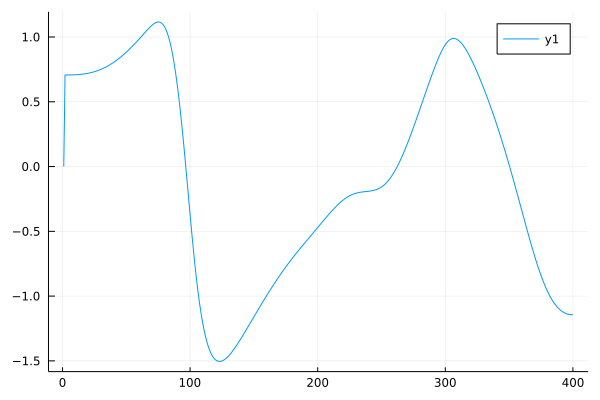

In [244]:
# Pure stance test vs double pendulum acrobot
begin
    x0 = [0.0; 0.0; pi/4; pi/4; 0; 0; 0; 0]
    # u0 = 2
    h = 0.01
    hopper = Hopper(1, 2, 1, 1.0, 1)
    T = 400
    Xs = zeros(T, 8)
    println("Begin")
    # Us = [zero(u0) for i = 1:T]
    x = x0
    # println(x)
    Xs[1, :] .= x0
    u = [0; 0]
    footCoords = zeros(T, 8)
    for i = 2:T
        # println(x)
        # println("X", x)
        # u = equilibrium(hopper, x, u, false, h)
        # x[5:6] .= [0.0, 0.0]
        # println(discrete_dynamics(hopper, x, u, false))
        rk4_dynamics!(hopper, x, u, false, h)
        Xs[i, :] .= x
        footCoords[i, :] .= foot_coords(hopper, x)
    end
    println("Done")
    # println(Xs[:, 4])
    
    # plot(Xs[:, 1])
    # plot!(Xs[:, 2])
    plot(footCoords[:, 1])
    # println(Xs[:, 2])
end

## Testing Acrobot vs the Compass Gait ##

In [35]:
function dynamics_rk4(a,x,u,h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [180]:
# Start MeshCat
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

[1.0, 1.0]
[0.7853981633974483, 0.0, 0.0, 0.0]


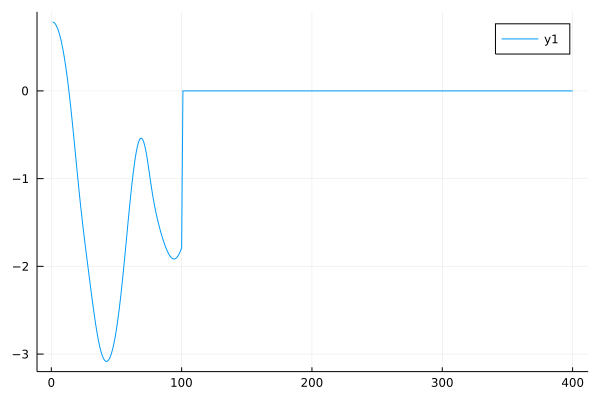

In [131]:
# Acrobot performance vs the Hopper: Acrobot version
begin
    a = RobotZoo.Acrobot()
    Xs = zeros(T, 4)
    T = 100
    h = 0.05
    x = [pi/4; 0.0; 0.0; 0.0]
    Xs[1, :] .= x
    println(a.m)
    println(x)
    for i = 2:T
        # println(x)
        # println("X", x)
        # u = equilibrium(hopper, x, u, false, h)
        # x[5:6] .= [0.0, 0.0]
        # println(discrete_dynamics(hopper, x, u, false))
        u = [0.0; 0.0]
        x = dynamics_rk4(a, x, u, h)
        Xs[i, :] .= x
    end
    TrajOptPlots.set_mesh!(vis, a)
    xtraj = [SVector{4}(Xs[i, :]) for i = 1:T]
    visualize!(vis, a, T*h, xtraj)
    plot(Xs[:, 1])
end

Begin
[0.0, 0.0, 2.356194490192345, -1.5707963267948966, 0.0, 0.0, 0.0, 0.0]
(4,)


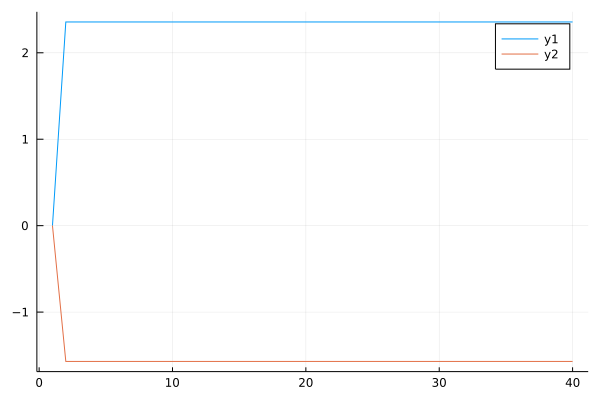

In [291]:
# Acrobot performance vs the Hopper: Acrobot version
begin
    x0 = [0.0; 0.0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    # u0 = 2
    h = 0.05
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    T = 40
    Xs = zeros(T, 8)
    println("Begin")
    # 
    x = x0
    println(x)
    Xs[1, :] .= x0
    FXs = zeros(T, 8)
    FXs[1, :] = foot_coords(hopper, x0)
    Ths = zeros(T, 4)
    u = [0; 0]
    Us = zeros(T, 2)
    for i = 2:T
        u = equilibrium(hopper, x, u, false, 7:8)
        rk4_dynamics!(hopper, x, u, false, h)
        fx = foot_coords(hopper, x)
        Xs[i, :] .= x
        # println(x)
        FXs[i, :] .= fx
        # println(x[4])
        Ths[i, :] .= [Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]
        Us[i, :] .= u
    end
    # Thtraj = zeros(T, 4)
    # println(Ths[1, :])
    # Thtraj[= [pi/2 - Xs[i, 3]; Xs[i, 4]; Xs[i, 7:8]]
    println(size(Ths[1, :]))
    ths = [SVector{4}([Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]) for i = 1:T]
    # println(Xs[:, 4])
    # plot(Xs[:, 1])
    # plot!(FXs[:, 2])
    TrajOptPlots.set_mesh!(vis, a)
    # xtraj = [SVector{4}(Xs[i, :]) for i = 1:T]
    visualize!(vis, a, T*h, ths)
    # plot(xtraj[:, 1])
    # println(Xs[:, 2])
    plot(Ths[:, 1:2])
    # plot!(Us)
end

Begin
[2.356194490192345, -1.5707963267948966, 0.0, 0.0]
[6.054061909490922 -12.765565331776122 -1.2886958875758414 -4.568503165335797; 5.966252461578381 -12.957827326389687 -2.2595189931322635 -3.0351285169448907; 5.826281874924817 -13.063015820948552 -3.3450573208873995 -1.126915032271447; 5.63195304764937 -13.066580189410962 -4.421087569696169 1.0179936861884789; 5.385218541795122 -12.958612220019756 -5.4316171451834085 3.3025965630540357; 5.091833119251662 -12.741015163704848 -6.242984569041402 5.258613990276322; 4.771508307188382 -12.460127048004669 -6.434724254202065 5.621048493918904; 4.46177840996661 -12.214169456904846 -5.861965395157625 3.9859734819026427]


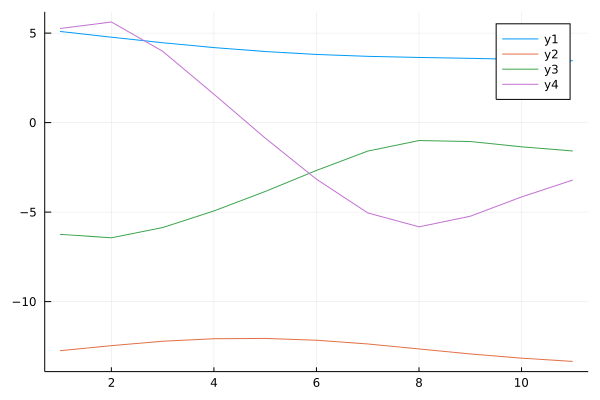